In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install jax
!pip install jaxlib
!pip install git+https://github.com/professorwug/diffusion-curvature
!pip install pygsp
!pip install graphtools
!pip install tqdm
!pip install nbdev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from diffusion_curvature.core import DiffusionCurvature, DiffusionLaziness

In [3]:
#Hyperparameters and model
batch_size = 128
num_epochs = 20
learning_rate = 0.01
dim_value = 16
output_directory = "./outputs"
os.makedirs(output_directory, exist_ok = True)
device = ("cuda" if torch.cuda.is_available() else "cpu")

class SimpleMLP(nn.Module):
  def __init__(self, num_classes=10):
    super(SimpleMLP, self).__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, dim_value),
        nn.ReLU(),
        nn.Linear(dim_value, num_classes)
        )

  def forward(self, x):
    x = self.flatten(x)
    output = self.layers(x)
    return output

In [4]:
#import datasets and initalize dataloader
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


In [5]:
# model initialization

model = SimpleMLP(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# A python hook to store stuff about penultimate embeddings
penultimate_embeddings = []
def hook_fn(module, input, output):
    # output shape: (batch_size, 256)
    embedding = output.detach().cpu().numpy()
    penultimate_embeddings.append(embedding)

hook = model.layers[2].register_forward_hook(hook_fn)

#Diffusion Curvature

Diff_curv = DiffusionCurvature(estimate_local_dimension=False)

In [6]:
!pip install 'phate'
import phate
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 82.1 MB/s eta 0:00:00
  Created wheel for s-gd2: filename=s_gd2-1.8.1-cp311-cp311-linux_x86_64.whl size=537219 sha256=b2d7c2c37075d99e37bd39e64cb8cdc0dde80eb6563c5df2bd79c5dd8ae62aa6
  Stored in directory: /root/.cache/pip/wheels/02/a3/d0/f92b1a96695e0792d1546fe2e108dabfcd31fca107ff39ead2
Successfully built s-gd2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
fastai 2.7

The loss in epoch 1 is 58.6631967894304. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 1) → mean 1.0644, std 0.9803


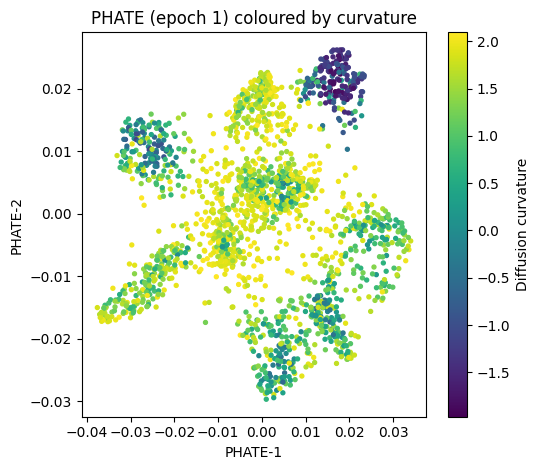

The loss in epoch 2 is 19.636783142333854. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {7}
Curvature (epoch 2) → mean -0.3568, std 0.9924


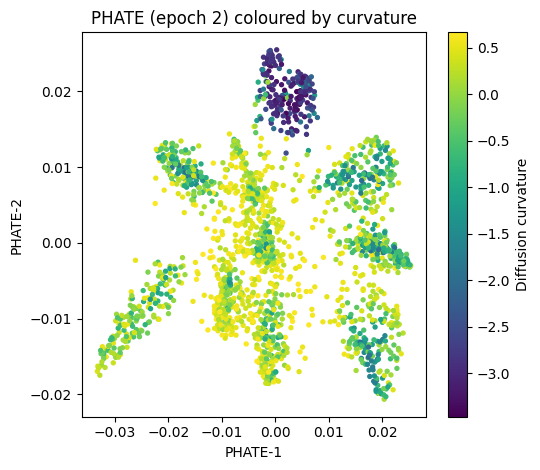

The loss in epoch 3 is 13.38686011493333. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 3) → mean 0.5231, std 1.0530


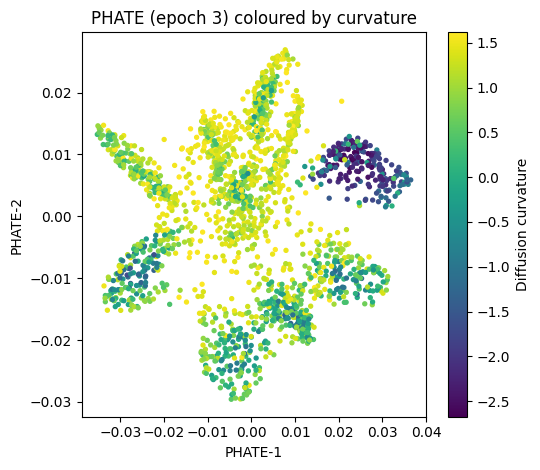

The loss in epoch 4 is 9.891764909727994. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 4) → mean 0.2830, std 1.0439


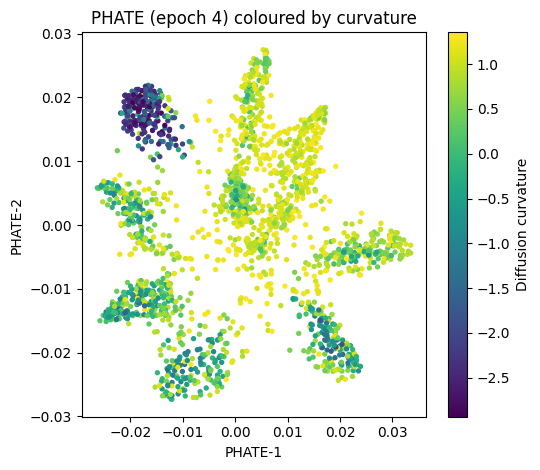

The loss in epoch 5 is 7.863240970731544. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 5) → mean 0.3936, std 1.0297


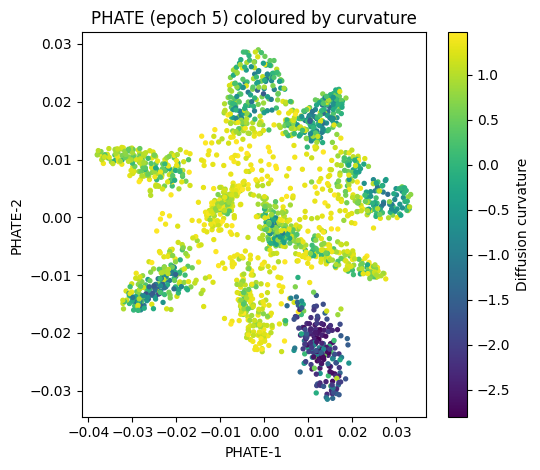

The loss in epoch 6 is 6.331802508088826. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 6) → mean 0.3681, std 1.0672


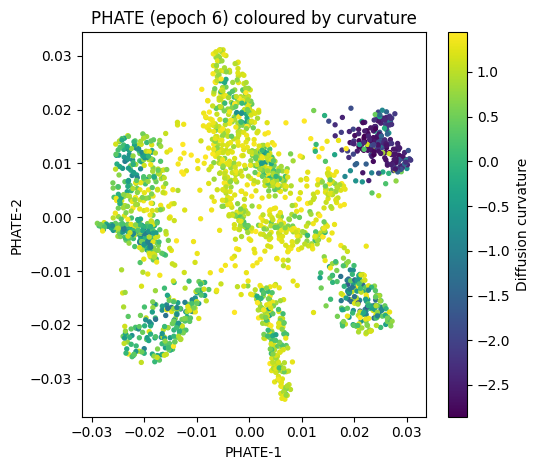

The loss in epoch 7 is 5.139400888099345. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 7) → mean 0.2670, std 1.0565


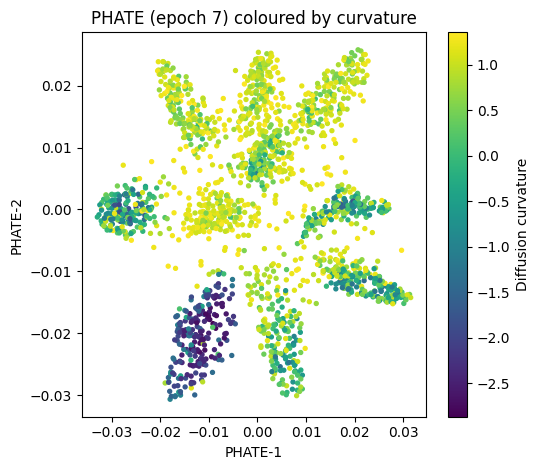

The loss in epoch 8 is 4.332767791267651. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 8) → mean 0.4265, std 1.0446


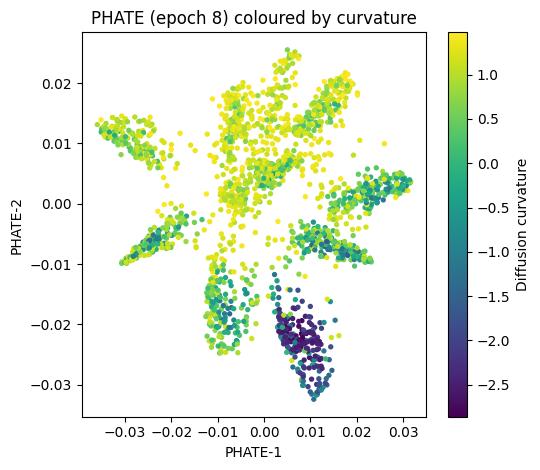

The loss in epoch 9 is 3.570317680139277. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 9) → mean 0.1050, std 1.0884


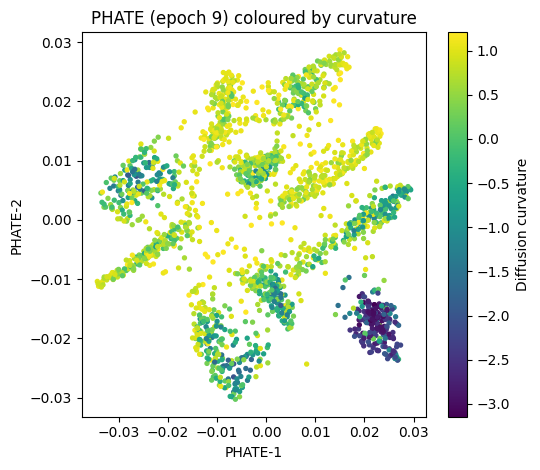

The loss in epoch 10 is 2.9993745279210464. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 10) → mean 0.5276, std 1.0734


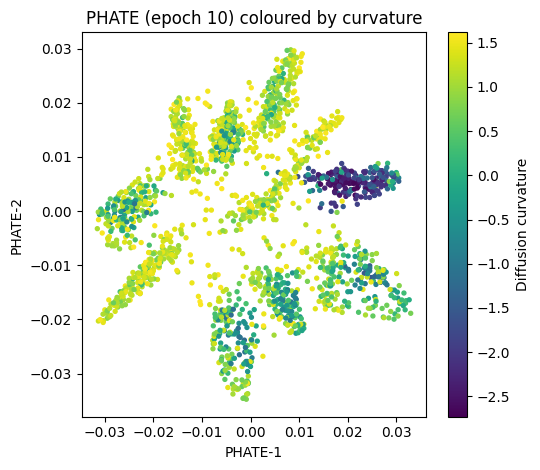

The loss in epoch 11 is 2.6547674372125027. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 11) → mean 0.5159, std 1.0363


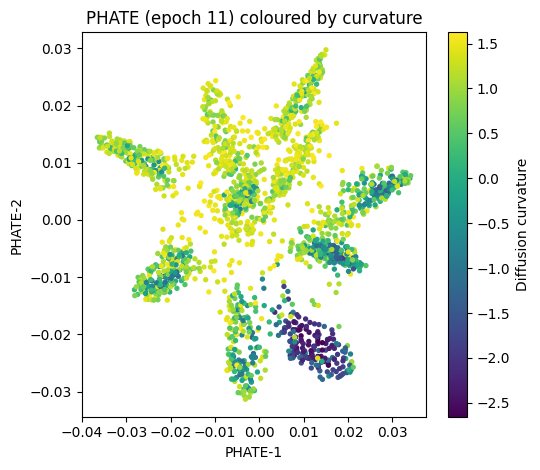

The loss in epoch 12 is 2.1313692187068303. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 12) → mean 1.0798, std 1.0271


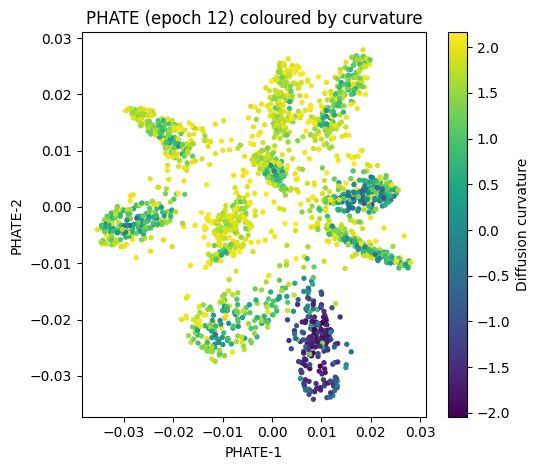

The loss in epoch 13 is 1.8580983524510601. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 13) → mean 0.4309, std 1.0924


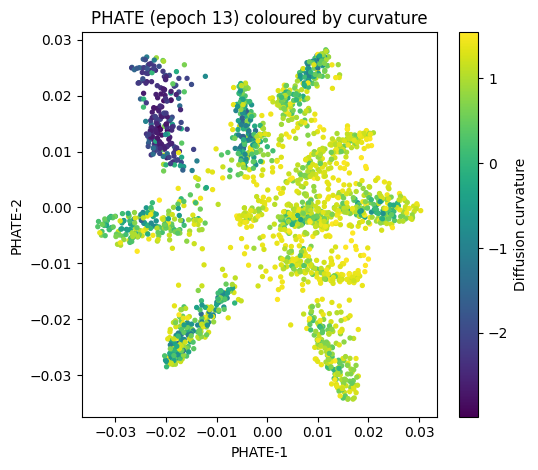

The loss in epoch 14 is 1.643330923148564. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 14) → mean 0.2868, std 1.0571


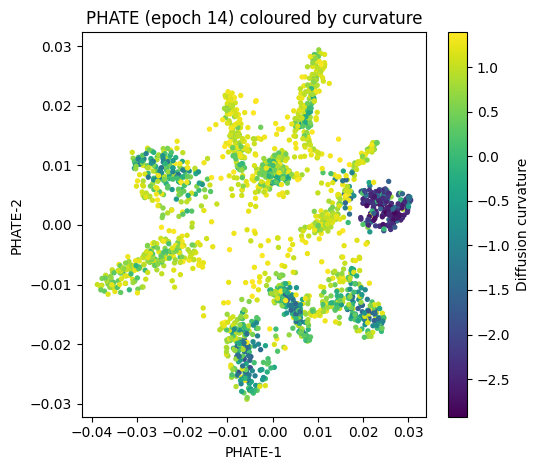

The loss in epoch 15 is 1.467413467893214. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {9}
Curvature (epoch 15) → mean 0.9780, std 1.0913


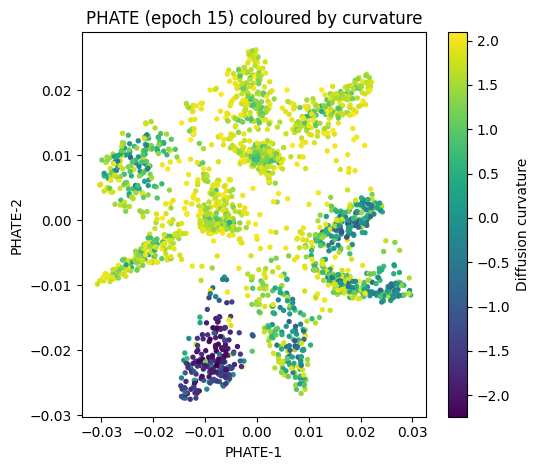

The loss in epoch 16 is 1.3026219169214082. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 16) → mean 0.6700, std 1.1624


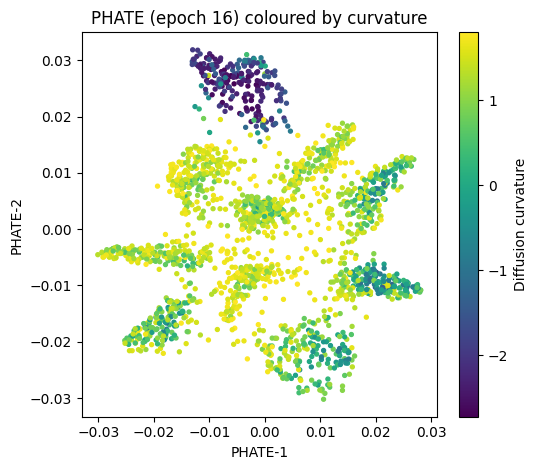

The loss in epoch 17 is 1.2718420860482686. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 17) → mean 0.5917, std 1.1151


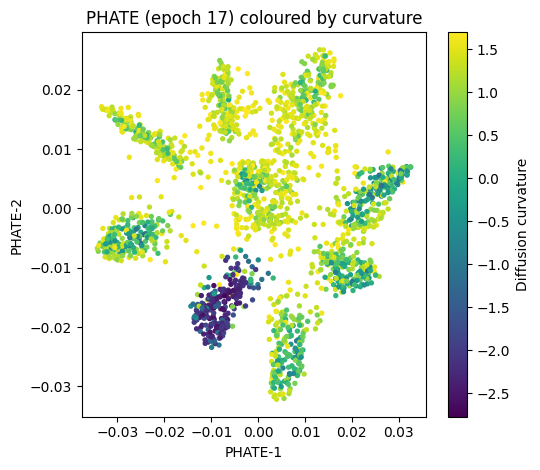

The loss in epoch 18 is 1.0493146453712032. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 18) → mean 0.1784, std 1.1095


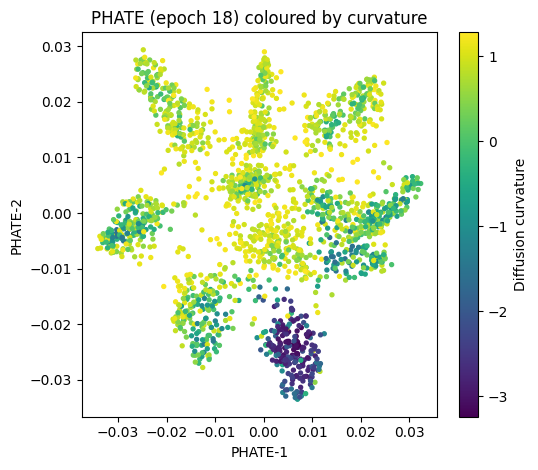

The loss in epoch 19 is 0.9840632983997687. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 19) → mean 0.6115, std 1.1203


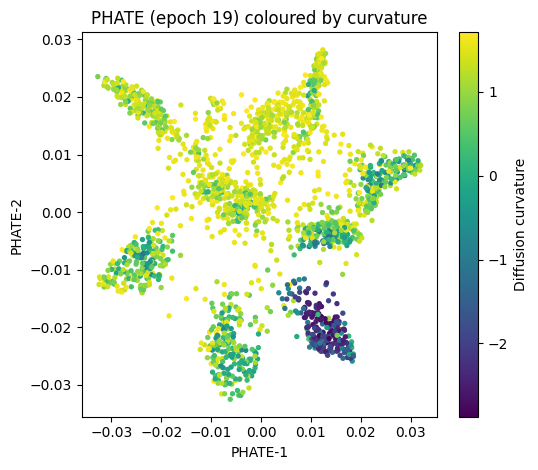

The loss in epoch 20 is 0.9350114915289605. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 20) → mean 0.5321, std 1.0679


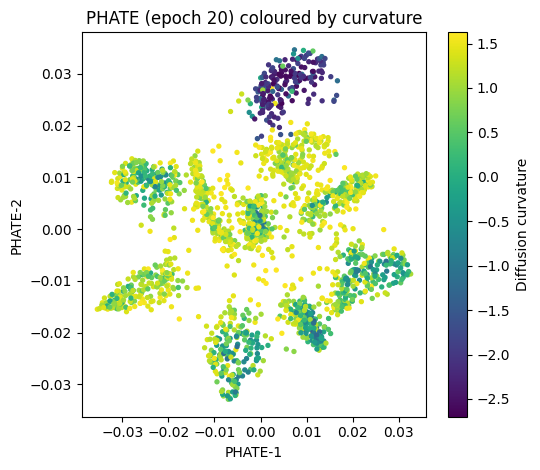

In [7]:
# Training the model and getting embeddings

def train():
  for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss/len(train_loader)
    print(f"The loss in epoch {epoch} is {epoch_loss}. ")

    penultimate_embeddings.clear()
    model.eval()
    with torch.no_grad():
            for images, _ in train_loader:
                images = images.to(device)
                _ = model(images)
    ebdgs = np.concatenate(penultimate_embeddings, axis=0)
    idx = np.random.choice(ebdgs.shape[0], 2000, replace=False)
    np.save(os.path.join(output_directory, f"feats_epoch_{epoch}_curv_dim{dim_value}.npy"), ebdgs)
    print(f"Saved penultimate embeddings shape: {ebdgs.shape}")
    curv = Diff_curv.fit_transform(
        X=ebdgs[idx],
        locality_scale=0.1,
        graph_knn=30
    )
    print(f"Curvature (epoch {epoch}) → mean {curv.mean():.4f}, std {curv.std():.4f}")
    np.save(os.path.join(output_directory,
                         f"curv_epoch_{epoch}_curv_dim{dim_value}.npy"),
            curv)

    phate_op = phate.PHATE(n_components=2, knn=30, n_jobs=-1, verbose=False)
    phate_2d = phate_op.fit_transform(ebdgs[idx])

    np.save(os.path.join(output_directory,
                         f"phate2d_epoch_{epoch}.npy"),
            phate_2d)

    # scatter plot coloured by curvature
    plt.figure(figsize=(5.5, 4.8))
    sc = plt.scatter(phate_2d[:, 0], phate_2d[:, 1], c=curv, s=8, cmap='viridis')
    plt.title(f'PHATE (epoch {epoch}) coloured by curvature')
    plt.xlabel('PHATE‑1');   plt.ylabel('PHATE‑2')
    plt.colorbar(sc, label='Diffusion curvature')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"phate2d_epoch_{epoch}.png"), dpi=300)
    plt.show()
    plt.close()



train()

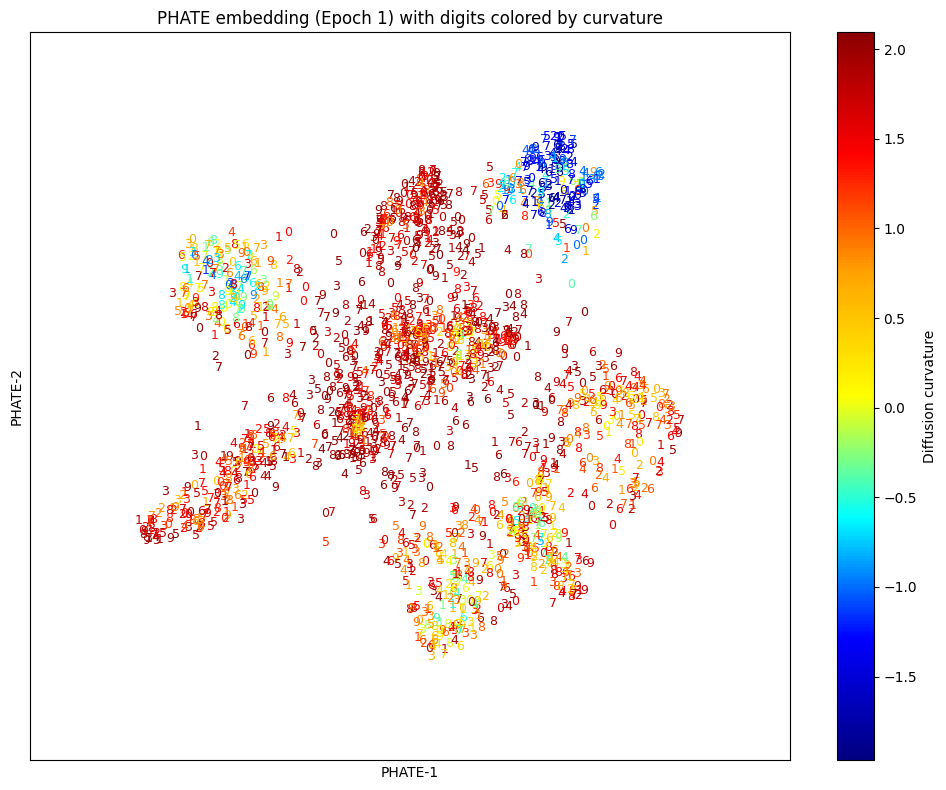

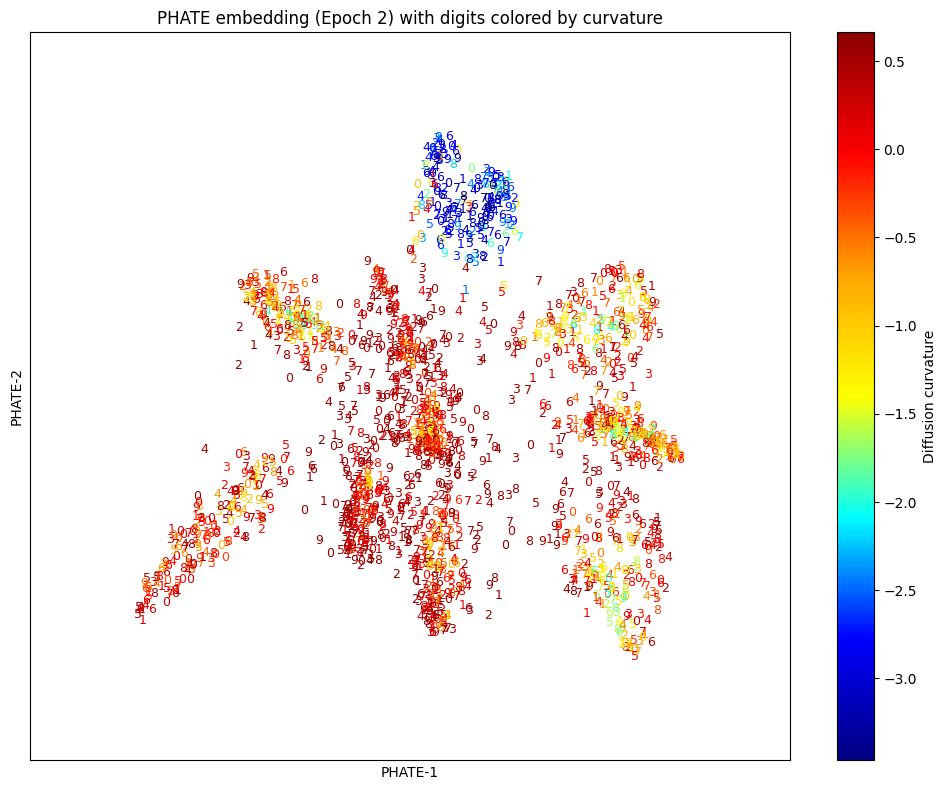

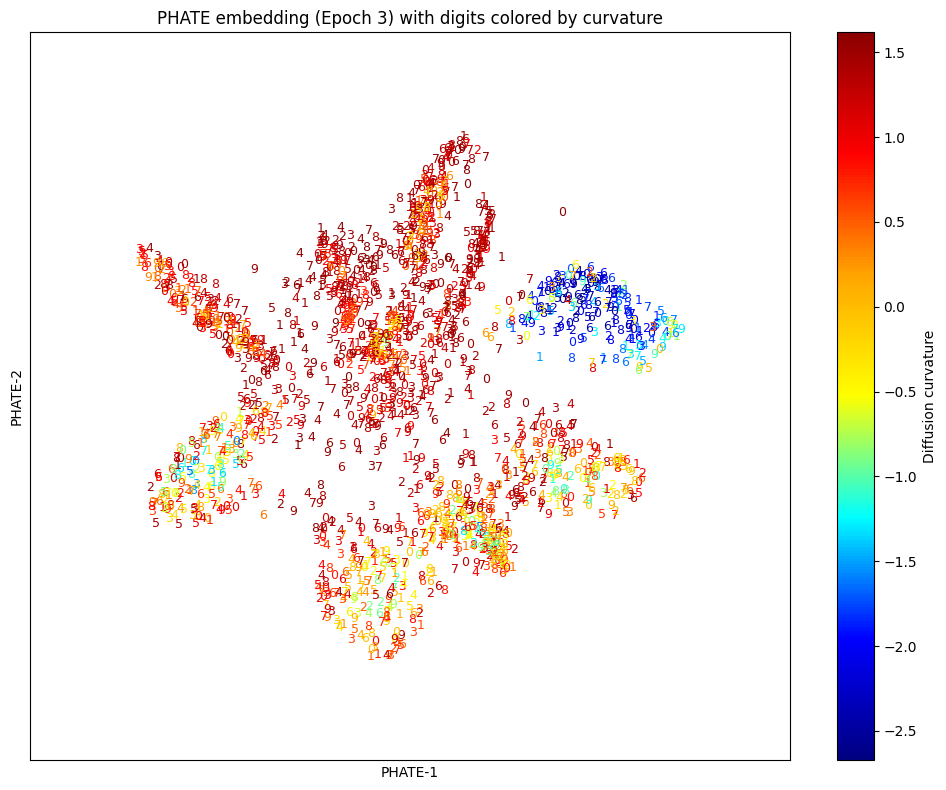

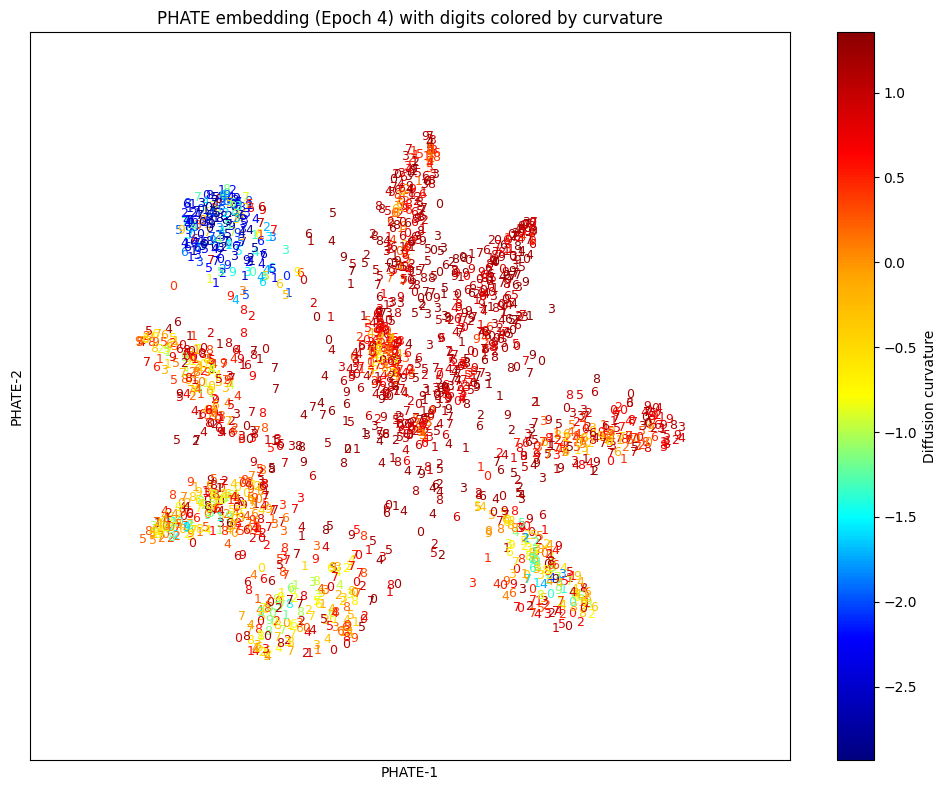

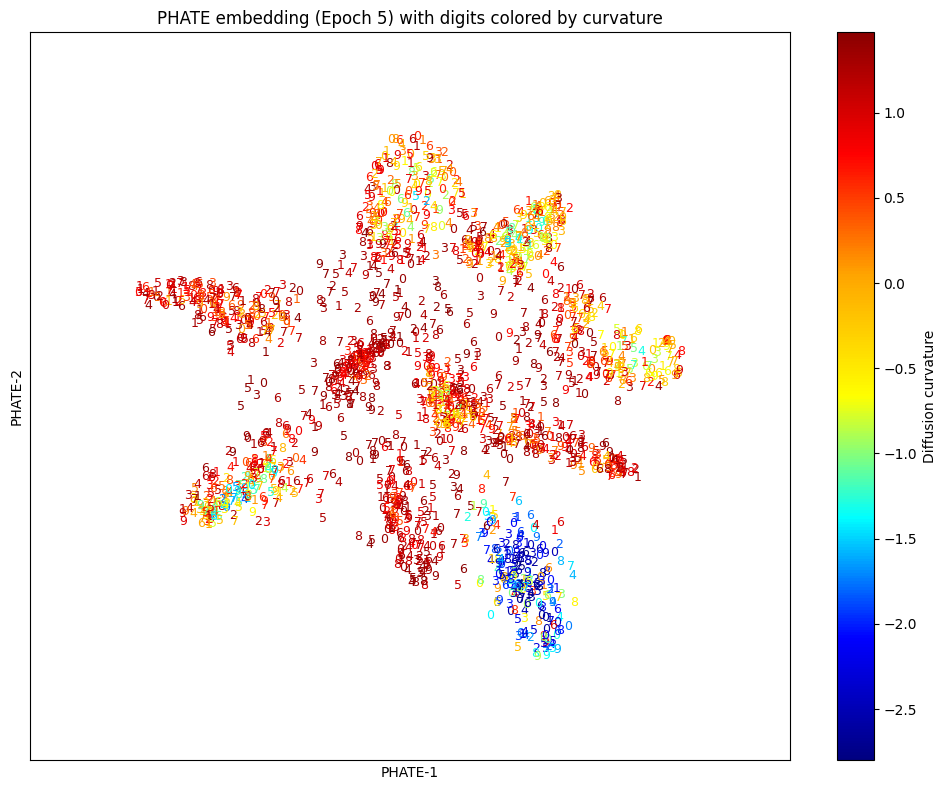

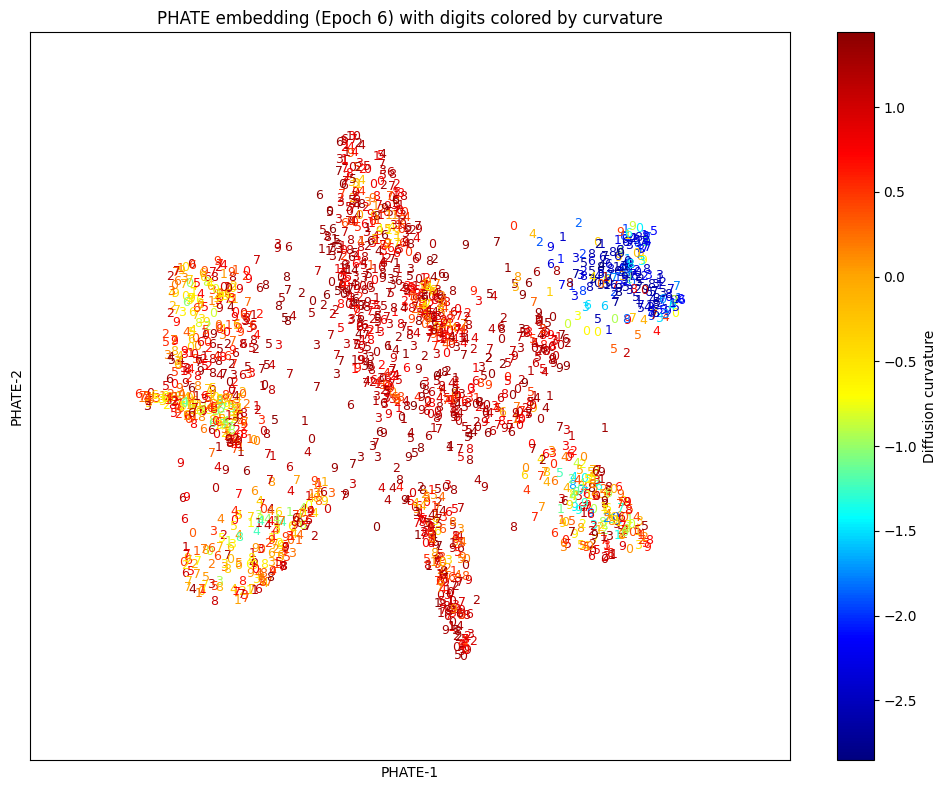

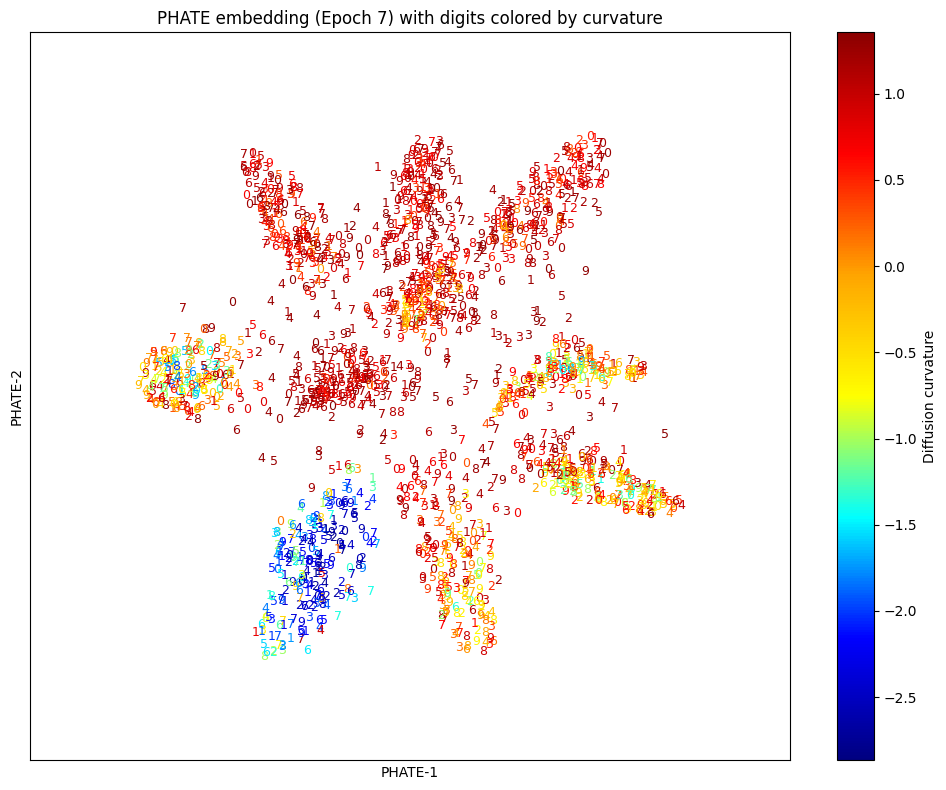

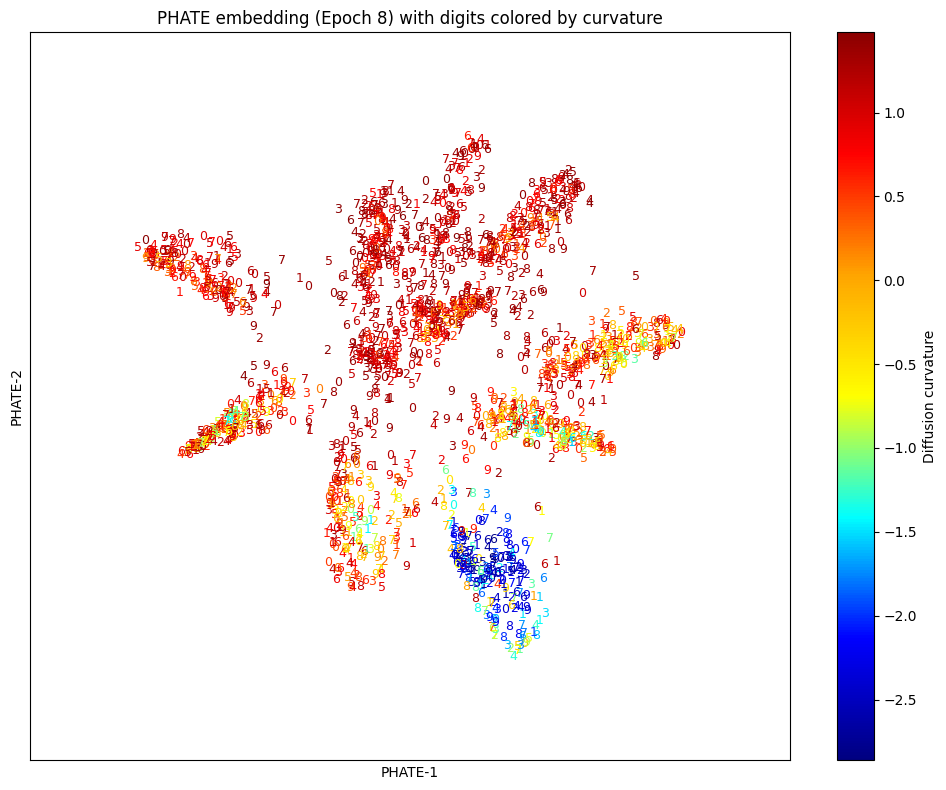

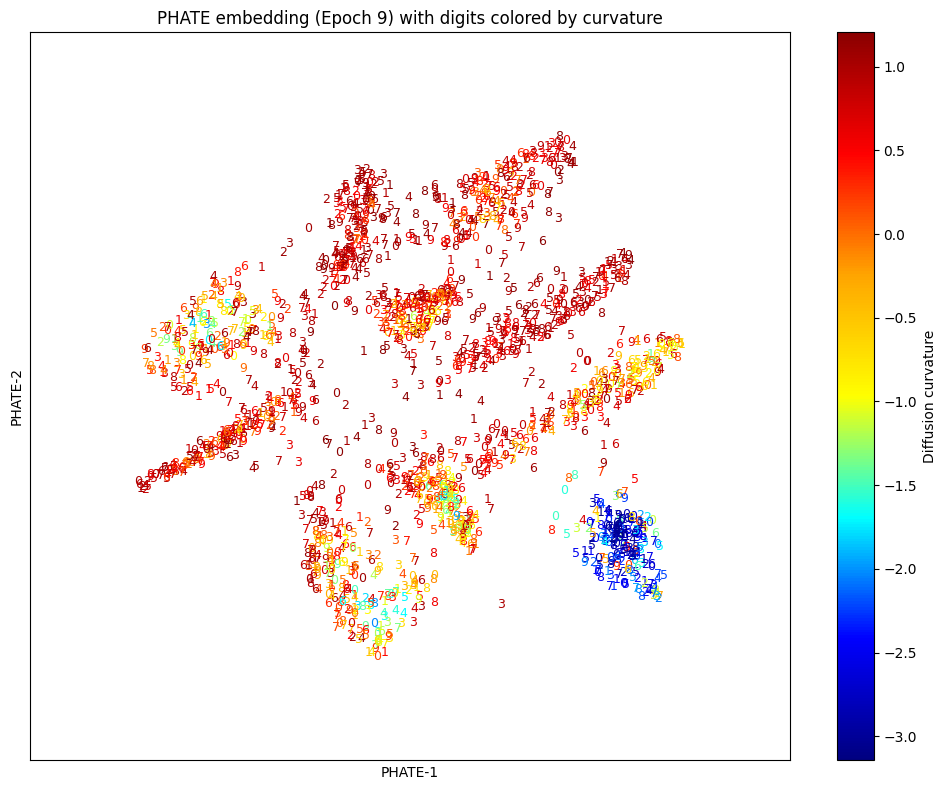

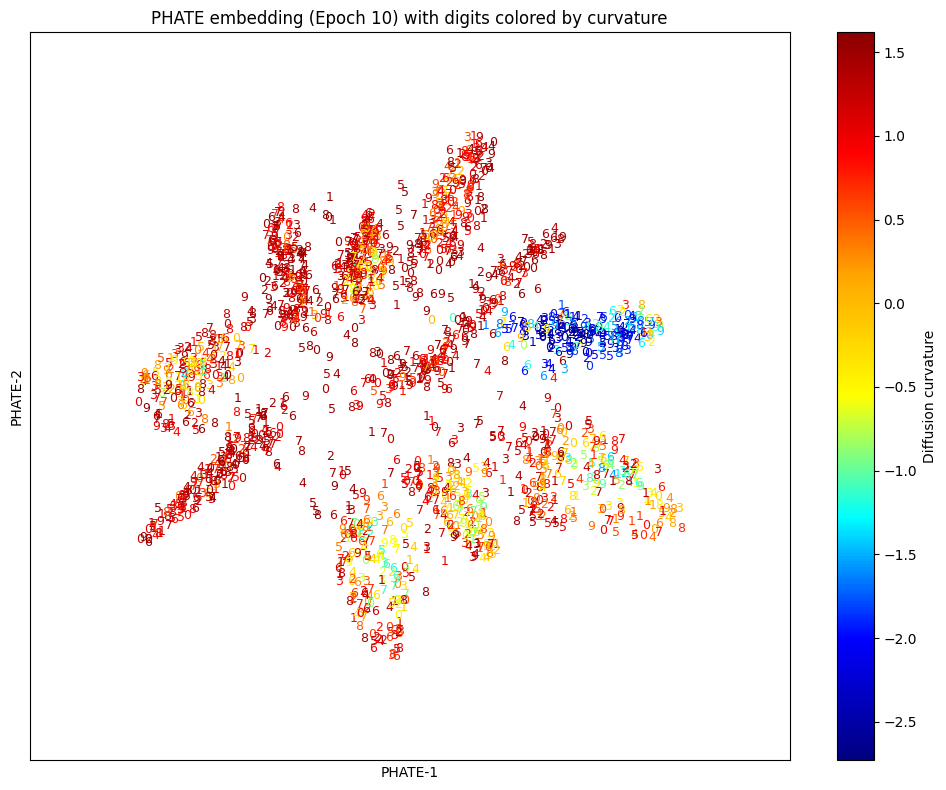

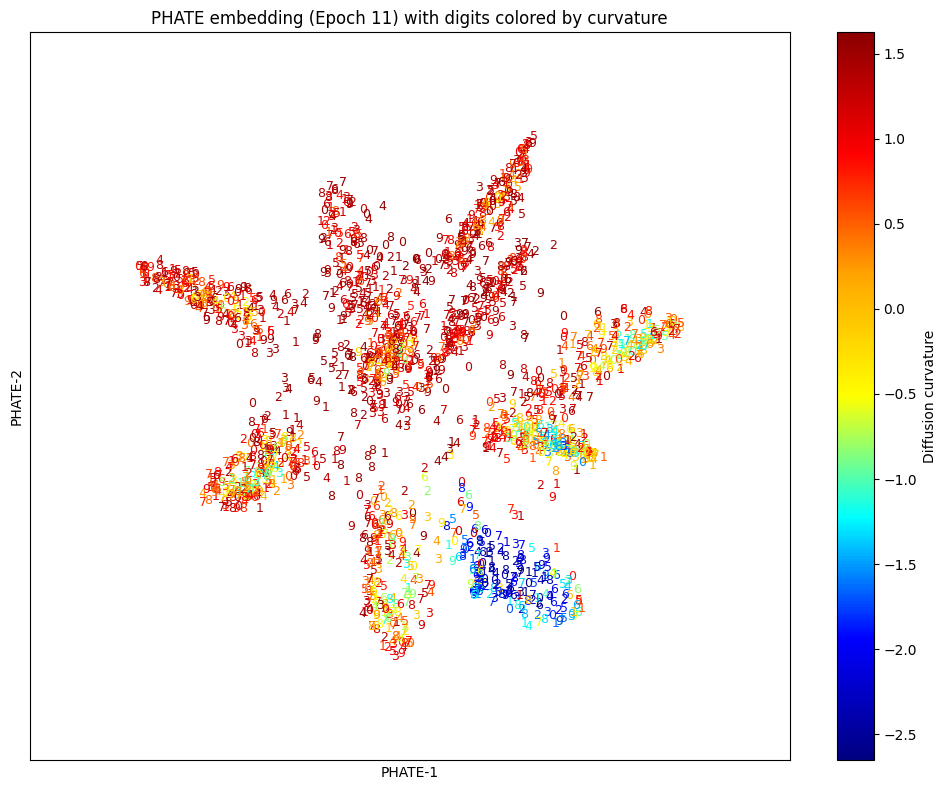

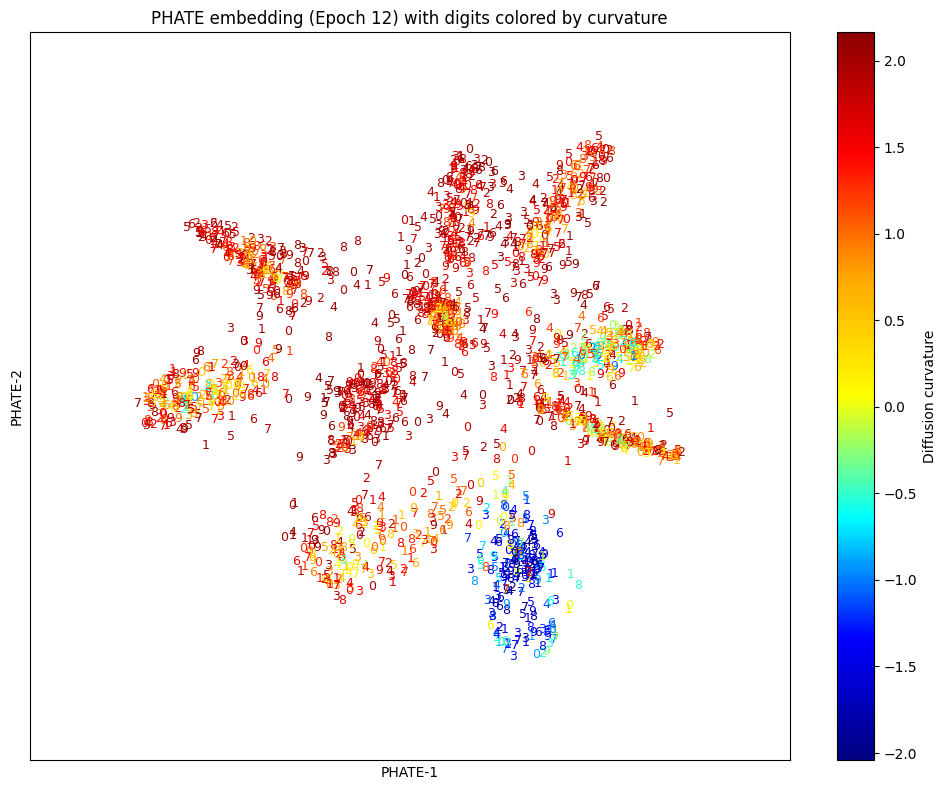

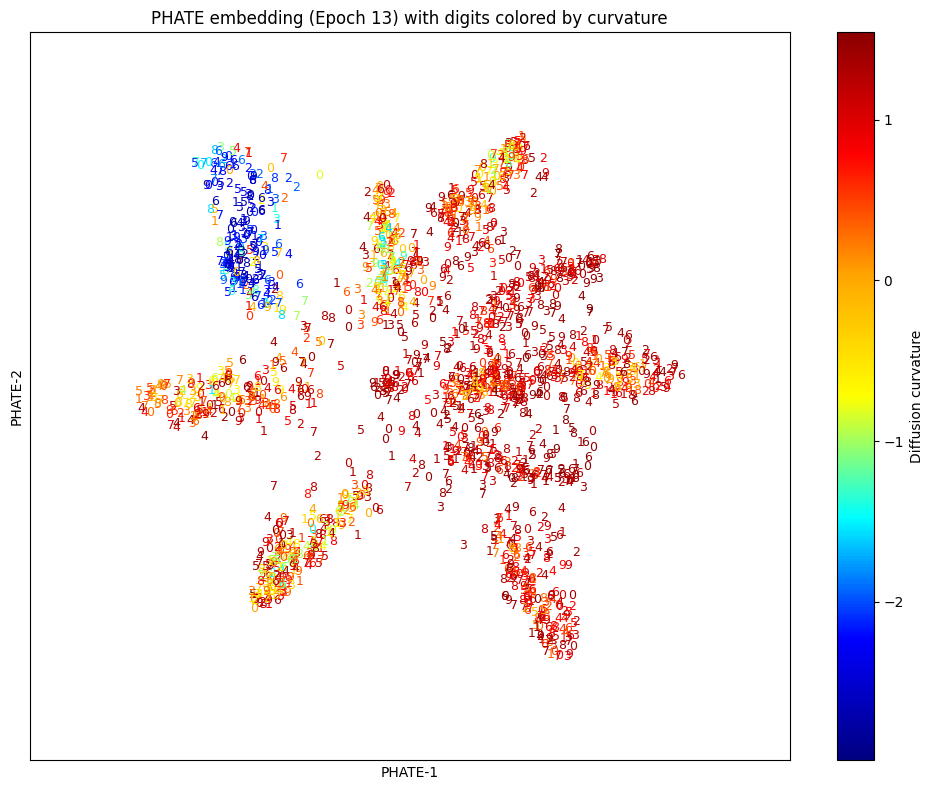

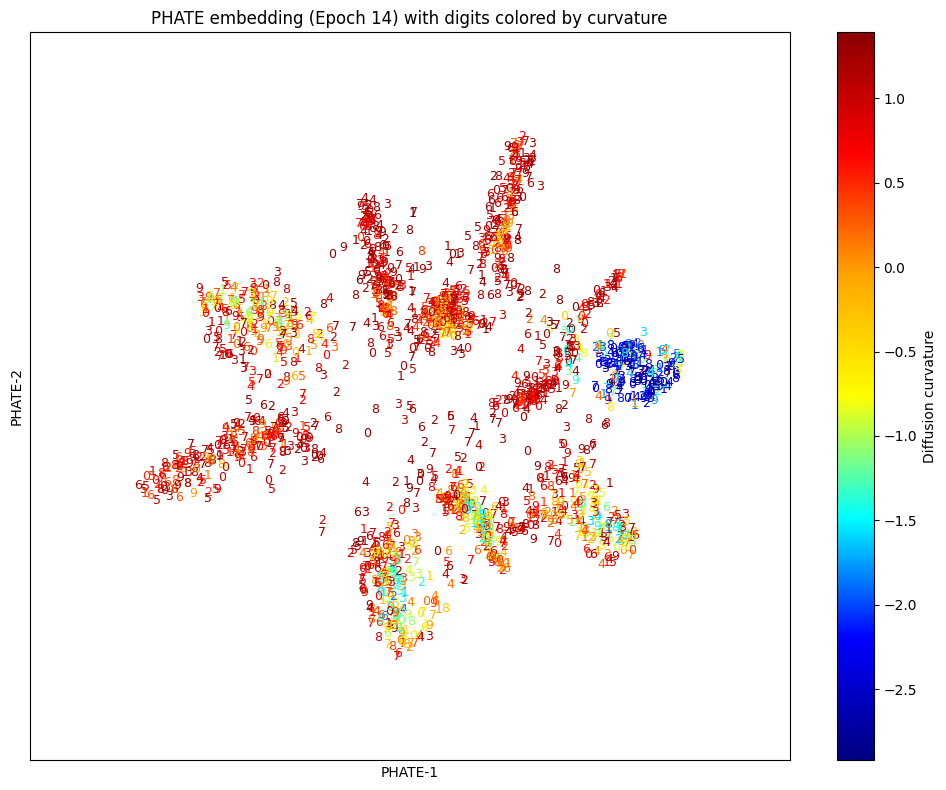

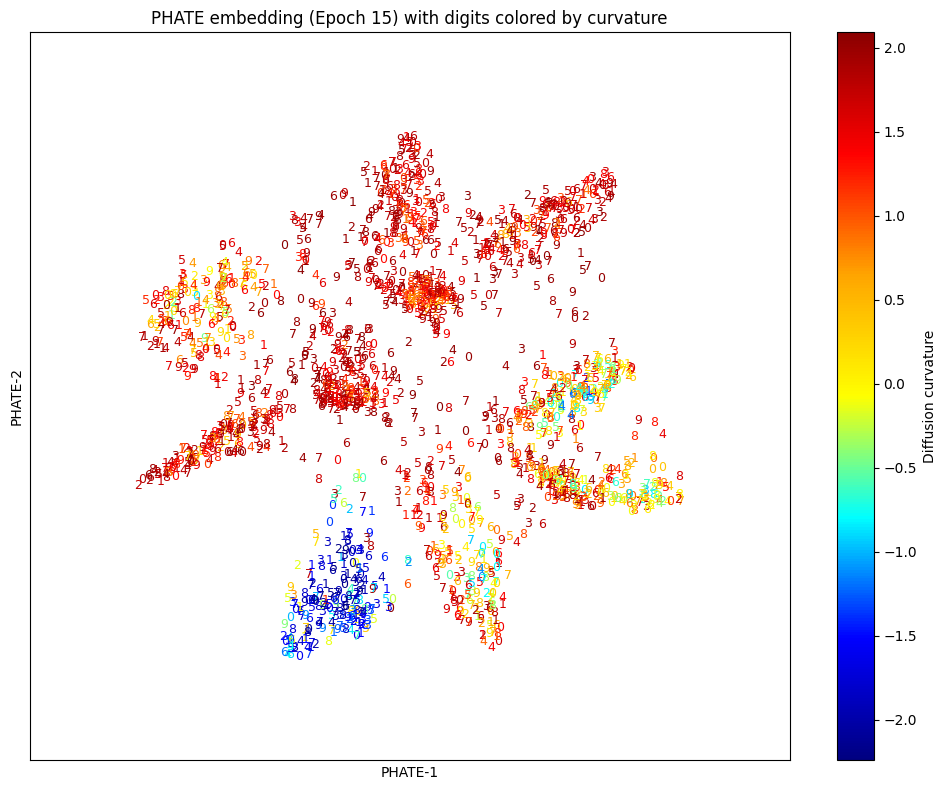

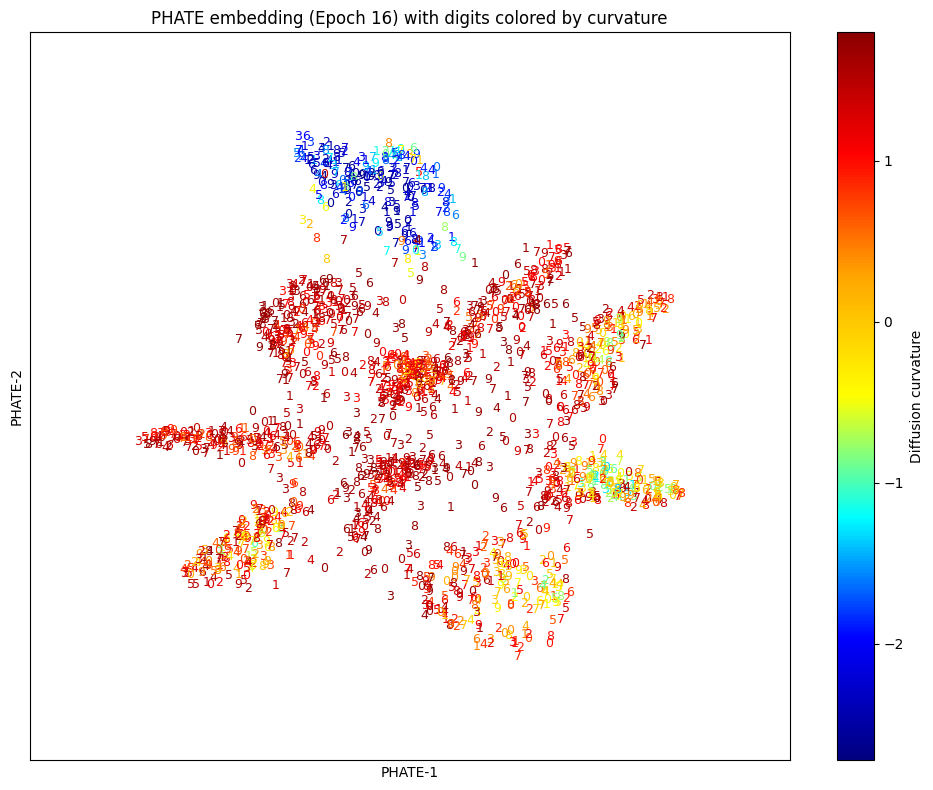

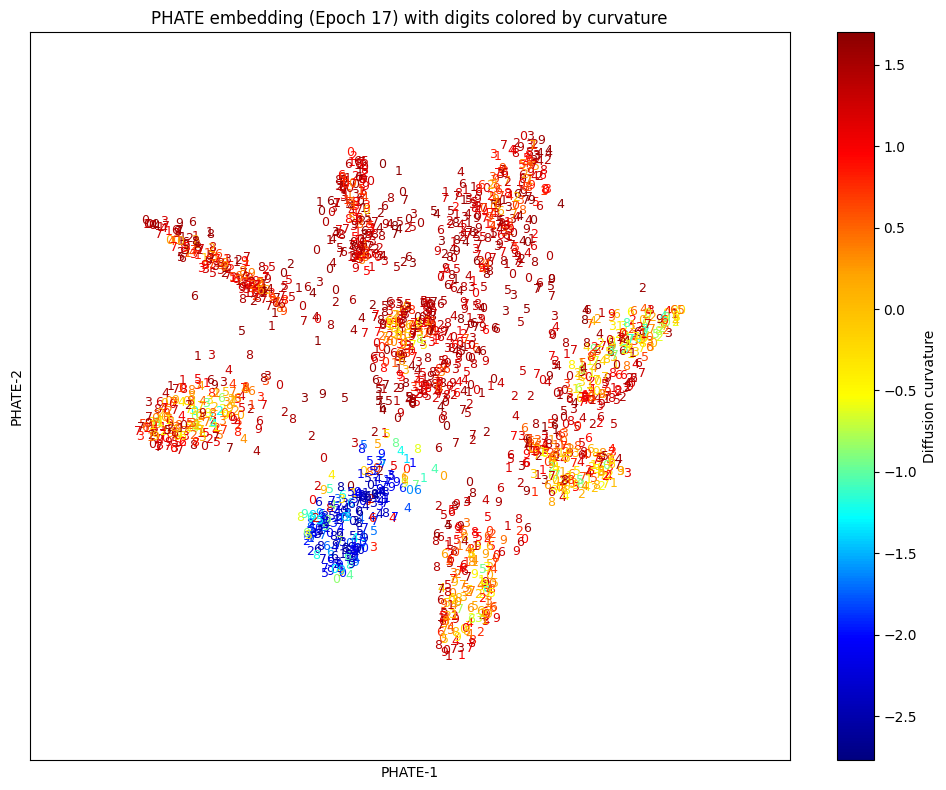

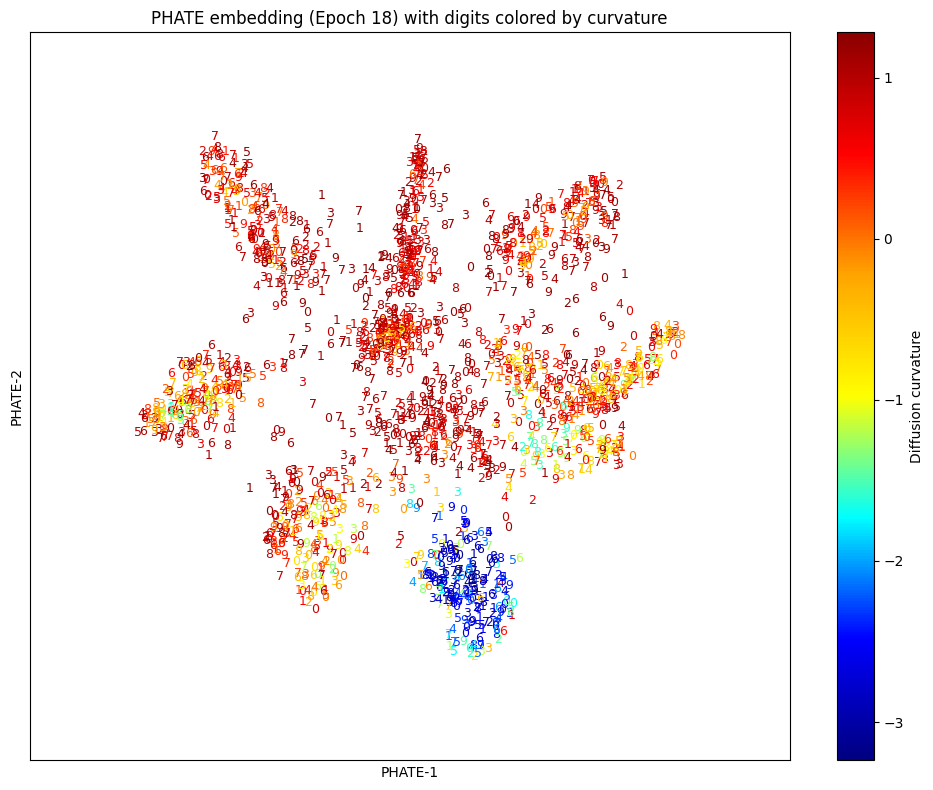

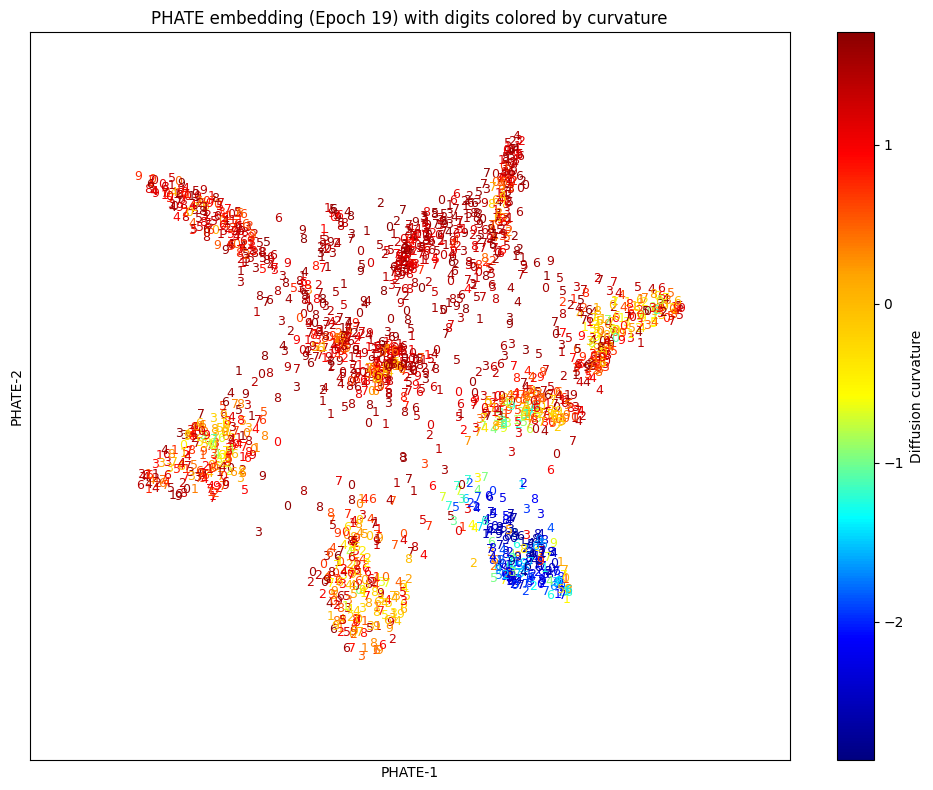

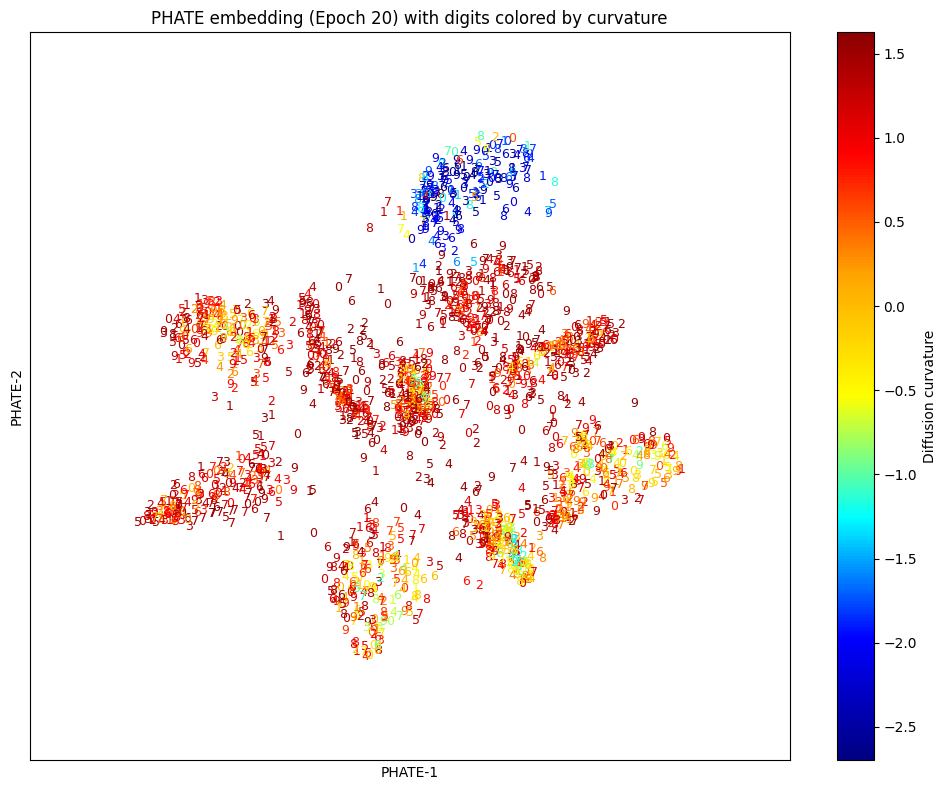

In [11]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

plots_folder = "./curvature_plots"
os.makedirs(plots_folder, exist_ok=True)

# load labels
all_labels = []
for _, label_batch in train_loader:
    all_labels.extend(label_batch.cpu().numpy())
all_labels = np.array(all_labels)

np.random.seed(42)
idx = np.random.choice(len(all_labels), 2000, replace=False)
digit_labels = all_labels[idx]

# create plots
for epoch in range(1, num_epochs + 1):
    phate_2d = np.load(os.path.join(output_directory, f"phate2d_epoch_{epoch}.npy"))
    curv = np.load(os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy"))

    fig, ax = plt.subplots(figsize=(10, 8))

    # custom color map for more differentiation
    colors = ["navy", "blue", "cyan", "yellow", "orange", "red", "darkred"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

    norm = Normalize(vmin=np.min(curv), vmax=np.max(curv))

    for i in range(len(phate_2d)):
        ax.text(phate_2d[i, 0], phate_2d[i, 1], str(digit_labels[i]),
                color=custom_cmap(norm(curv[i])),
                fontsize=9, ha='center', va='center')


    # set axes limits
    x_min, x_max = np.min(phate_2d[:, 0]), np.max(phate_2d[:, 0])
    y_min, y_max = np.min(phate_2d[:, 1]), np.max(phate_2d[:, 1])

    x_padding = (x_max - x_min) * 0.2
    y_padding = (y_max - y_min) * 0.2

    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Diffusion curvature')

    ax.set_title(f'PHATE embedding (Epoch {epoch}) with digits colored by curvature')
    ax.set_xlabel('PHATE-1')
    ax.set_ylabel('PHATE-2')

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"phate2d_digits_colored_epoch_{epoch}.png"), dpi=300)
    plt.show()

In [12]:
!zip -r /content/content_folder.zip /content

from google.colab import files
files.download('/content/content_folder.zip')

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.05.02/ (stored 0%)
  adding: content/.config/logs/2025.05.02/13.32.47.744427.log (deflated 93%)
  adding: content/.config/logs/2025.05.02/13.33.18.977287.log (deflated 58%)
  adding: content/.config/logs/2025.05.02/13.33.17.734755.log (deflated 87%)
  adding: content/.config/logs/2025.05.02/13.33.28.819597.log (deflated 57%)
  adding: content/.config/logs/2025.05.02/13.33.28.09

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>